# Construyo indicadores

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [ ]:
df = yf.download('GGAL', auto_adjust=True)

data = df.copy()
cruces = [(5,20),(15,60),(50,100)]

for i in range(len(cruces)):
    sma_fast = data.Close.rolling(cruces[i][0]).mean()
    sma_slow = data.Close.rolling(cruces[i][1]).mean()
    data[f"cruce_{i+1}"] = sma_fast / sma_slow
data.dropna(inplace=True)
data.head(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,cruce_1,cruce_2,cruce_3
Date,,,,,,,,
2000-12-13,12.326536,12.482568,11.858440,12.066483,249900,1.018333,1.002920,0.923234
2000-12-14,12.118492,12.170503,11.806428,11.858438,203200,1.018796,1.004983,0.924557
2000-12-15,11.754418,11.806429,11.650397,11.754418,362000,1.018158,1.004990,0.925879
2000-12-18,12.066484,12.378548,12.014473,12.222516,356200,1.014831,1.005140,0.928354
2000-12-19,12.274525,12.326535,12.118493,12.274525,321200,1.012415,1.009715,0.931139
2000-12-20,12.222515,12.950664,11.910450,12.066483,110300,1.012636,1.013267,0.933783
2000-12-21,12.014471,12.586589,12.014471,12.586589,231500,1.021091,1.018727,0.936432
2000-12-22,12.638601,12.794633,12.534580,12.690612,170300,1.033857,1.024850,0.940298
2000-12-26,12.638600,12.742622,12.586590,12.638600,125700,1.039232,1.033181,0.943767


# Construcción de "Sintéticos"

In [ ]:
data = data.dropna()
frisk = 0.00005  # un 0.00005 sobre la unidad *250, equivale a 1.25% anual

sinteticos = pd.DataFrame(index=data.index)
sinteticos['BuyHold'] = data.Close.pct_change()
sinteticos['cruce_1'] = np.where(data.cruce_1.shift() > 1, data.Close.pct_change(), frisk)
sinteticos['cruce_2'] = np.where(data.cruce_2.shift() > 1, data.Close.pct_change(), frisk)
sinteticos['cruce_3'] = np.where(data.cruce_3.shift() > 1, data.Close.pct_change(), frisk)

w = {'BuyHold':0, 'cruce_1':0.25, 'cruce_2':0.3, 'cruce_3':0.45}
weights = np.array(list(w.values()))

sinteticos['composicion_final'] = np.dot(sinteticos, weights)

In [ ]:
sinteticos

,BuyHold,cruce_1,cruce_2,cruce_3,composicion_final
Date,,,,,
2000-12-13,NaN,0.000050,0.000050,0.00005,NaN
2000-12-14,-0.017241,-0.017241,-0.017241,0.00005,-0.009460
2000-12-15,-0.008772,-0.008772,-0.008772,0.00005,-0.004802
2000-12-18,0.039823,0.039823,0.039823,0.00005,0.021925
2000-12-19,0.004255,0.004255,0.004255,0.00005,0.002363
...,...,...,...,...,...
2023-06-06,0.129765,0.129765,0.129765,0.00005,0.071393
2023-06-07,0.040919,0.040919,0.040919,0.00005,0.022528
2023-06-08,0.012414,0.012414,0.012414,0.00005,0.006850


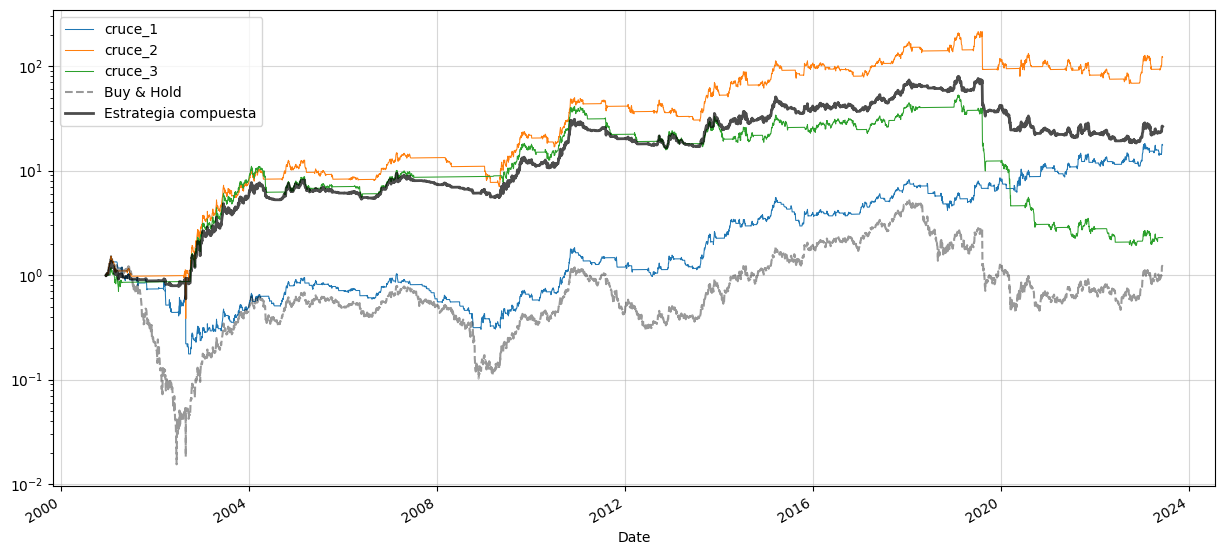

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))


sinteticos_px = (sinteticos+1).cumprod()

estrategias = ['cruce_1','cruce_2','cruce_3']
sinteticos_px.loc[:,estrategias].plot(ax=ax, lw=0.75)
ax.set_yscale('log')
ax.plot(sinteticos_px.BuyHold, color='k', alpha=0.4, ls='--', label='Buy & Hold')
ax.plot(sinteticos_px.composicion_final, color='k', alpha=0.7, lw=2, label='Estrategia compuesta')
ax.grid(alpha=0.5)
ax.legend()
#sinteticos_px.plot(logy=True, figsize=(15,7))

<Axes: xlabel='Date'>

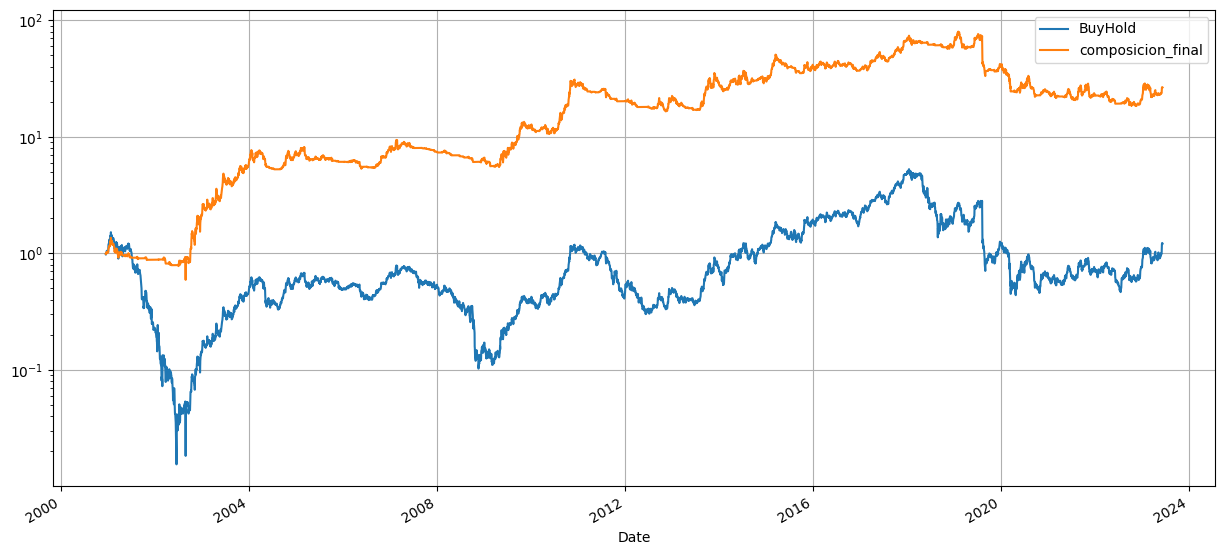

In [ ]:
sinteticos_px.loc[:,['BuyHold', 'composicion_final']].plot(logy=True, figsize=(15,7), grid=True)

# Análisis de métricas

In [ ]:
strategy = sinteticos_px['composicion_final']
benchmark = sinteticos_px['BuyHold']

strategy_log = np.log (strategy / strategy.shift())
benchmark_log = np.log (benchmark / benchmark.shift())

strategy_lin = strategy.pct_change()
benchmark_lin = benchmark.pct_change()

## Retorno Acumulado

In [ ]:
retorno_acum = ((strategy_lin+1).prod()-1)
retorno_acum

25.725828286849847

In [ ]:
print(f'Retorno acumulado Estrategia: {retorno_acum:.2%}')

Retorno acumulado Estrategia: 2572.58%


In [ ]:
retorno_acum_bench = ((benchmark_lin+1).prod()-1)
print(f'Retorno acumulado Benchmark: {retorno_acum_bench:.2%}')

Retorno acumulado Benchmark: 23.12%


## CAGR

$$  \Large  \frac{v_f}{v_i} = (1+r)^t  $$

In [ ]:
años = (strategy_lin.index[-1]-strategy_lin.index[0]).days / 365

años

22.50958904109589

In [ ]:
retorno_acum = (strategy_lin+1).prod()-1

years = (strategy_lin.index[-1]-strategy_lin.index[0]).days/365
cagr_st = (1+retorno_acum)**(1/years)-1
f"{cagr_st:.2%}, {retorno_acum:.2%}"

'15.72%, 2572.58%'

In [ ]:
retorno_acum = (benchmark_lin+1).prod()-1

years = (benchmark_lin.index[-1]-benchmark_lin.index[0]).days/365
cagr_bench = (1+retorno_acum)**(1/years)-1

f"{cagr_bench:.2%}, {retorno_acum:.2%}"

'0.93%, 23.12%'

## Volatilidad

In [ ]:
volatilidad = strategy_lin.std() * 252**0.5
volatilidad

0.36944665059841175

In [ ]:
volatilidad_bench = benchmark_lin.std() * 252**0.5
volatilidad_bench

0.7823900758841454

## Sharpe

### Con un rolling

In [ ]:
# sharpe ratio = ( retorno - freeRisk ) / volatilidad

(0.47136454489580054, <Axes: xlabel='Date'>)

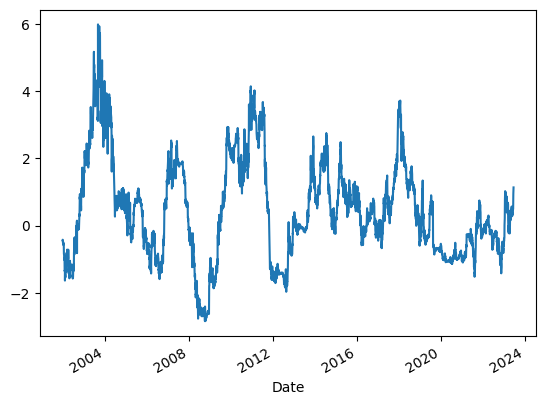

In [ ]:
w = 252
fr = 0

roll_ret = strategy.pct_change(w)
roll_std = (strategy_lin.rolling(w).std() * (w**.5))

roll_sharpe = (roll_ret - fr) / roll_std
roll_sharpe.mean(), roll_sharpe.plot()

### Con los agregados anualizados

In [ ]:
cagr_st / volatilidad

0.4253838182601797

### Anualizando los diarios

In [ ]:
strategy_lin.mean() / strategy_lin.std() * (252**0.5)

0.5819409134000426

## Sortino

In [ ]:
strategy_lin[strategy_lin < 0]

Date
2000-12-15   -0.004802
2000-12-20   -0.009300
2000-12-26   -0.002232
2000-12-27   -0.004504
2000-12-28   -0.004542
                ...   
2023-05-18   -0.006508
2023-05-22   -0.005913
2023-05-25   -0.002516
2023-06-02   -0.012260
2023-06-12   -0.007776
Name: composicion_final, Length: 2147, dtype: float64

In [ ]:
def sortino(returns):
    semi_desv = (((returns[returns < 0] - returns[returns < 0].mean() ) **2).sum() /len(returns[returns < 0])) **.5
    return returns.mean() / semi_desv * (252**0.5)

# Este es el que usa el autor de la libreria
def sortino(returns):
    semi_desv = ((returns[returns < 0] **2).sum() /len(returns)) **.5
    return returns.mean() / semi_desv * (252**0.5)

In [ ]:
sortino(strategy_lin), sortino(benchmark_lin)

(0.8855115276009985, 0.6143928897623303)

## Max DrawDown

<Axes: xlabel='Date'>

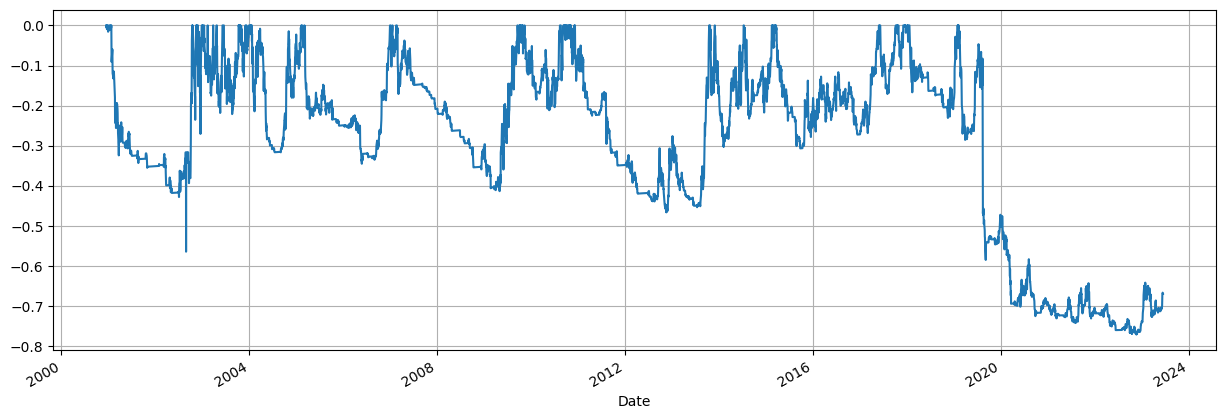

In [ ]:
(strategy / strategy.cummax()-1).plot(figsize=(15,5), grid=True)

In [ ]:
max_dd_st = (strategy / strategy.cummax()-1).min()
max_dd_bench = (benchmark / benchmark.cummax()-1).min()

max_dd_st, max_dd_bench

(-0.7701531879868388, -0.9898030225290015)

## Max DrawDown Dias

In [ ]:
maximos_mascara = strategy.cummax() == strategy
maximos_mascara

Date
2000-12-13    False
2000-12-14     True
2000-12-15    False
2000-12-18     True
2000-12-19     True
              ...  
2023-06-06    False
2023-06-07    False
2023-06-08    False
2023-06-09    False
2023-06-12    False
Name: composicion_final, Length: 5658, dtype: bool

In [ ]:
pd.Series(maximos_mascara.loc[maximos_mascara].index).diff().sort_values(ascending=False).head(10)

117   1043 days
72     938 days
137    800 days
66     666 days
14     629 days
64     385 days
163    375 days
87     275 days
121    224 days
124    217 days
Name: Date, dtype: timedelta64[ns]

In [ ]:
pd.Series(maximos_mascara.loc[maximos_mascara].index).diff().max().days

1043

In [ ]:
maximos_mascara = strategy.cummax() == strategy

pd.Series(maximos_mascara.loc[maximos_mascara].index).diff().max()

Timedelta('1043 days 00:00:00')

## r^2

In [ ]:
r2 = strategy_lin.corr(benchmark_lin)**2
r2

0.5437767809667645

## CALMAR Ratio

El problema es que queda relativo a la cantidad de años del periodo

- Muchos años hacen "bajar" o estabilizar valores de CAGR en torno al 5%/7%
- Muchos años hacen "subir" o marcar un piso de drawdown del orden del 40% promedio en equity


=> No hay un valor de referencia como en otros indicadores por ej. sharpe >1, o tailRisk >1

In [ ]:
calmar_st = cagr_st / -max_dd_st
calmar_bench = cagr_bench / -max_dd_bench

calmar_st, calmar_bench

(0.20405891883118782, 0.009378145726213902)

## Asimetria y Kurtosis

In [ ]:
strategy_lin.skew(), benchmark_lin.skew()

(1.2548620390357446, 10.50366351288814)

In [ ]:
strategy_lin.kurtosis(), benchmark_lin.kurtosis()

(95.32286973250139, 404.06766681959994)

## Rendimientos diario mensual y anual

In [ ]:
# Resampleo

mensual_st = strategy.resample('M').last()
mensual_bench = benchmark.resample('M').last()

mensual_st_ret = mensual_st / mensual_st.shift() -1
mensual_bench_ret = mensual_bench / mensual_bench.shift() -1

q_meses = len(mensual_st)

In [ ]:
# Esperanza

mensual_exp_st = (mensual_st.iloc[-1] / mensual_st.dropna().iloc[0]) ** (1/q_meses)-1
mensual_exp_bench = (mensual_bench.iloc[-1] / mensual_bench.dropna().iloc[0]) ** (1/q_meses)-1

mensual_exp_st, mensual_exp_bench

(0.012115685994608105, 0.0006247973313202593)

In [ ]:
# Minimos

mensual_st_min = mensual_st_ret.min()*100
mensual_bench_min = mensual_bench_ret.min()*100

mensual_st_min, mensual_bench_min

(-51.637787436144535, -70.49537190234845)

In [ ]:
# Máximos

mensual_st_max = mensual_st_ret.max()*100
mensual_bench_max = mensual_bench_ret.max()*100

mensual_st_max, mensual_bench_max

(58.31265749252474, 75.00001646293961)

In [ ]:
def getResampleMetrics(period='M'):

    resample_st = strategy.resample(period).last()
    resample_bench = benchmark.resample(period).last()

    resample_st_ret = resample_st / resample_st.shift() -1
    resample_bench_ret = resample_bench / resample_bench.shift() -1

    q = len(resample_st)

    resample_exp_st = (resample_st.iloc[-1] / resample_st.dropna().iloc[0]) ** (1/q)-1
    resample_exp_bench = (resample_bench.iloc[-1] / resample_bench.dropna().iloc[0]) ** (1/q)-1

    resample_st_min = resample_st_ret.min()*100
    resample_bench_min = resample_bench_ret.min()*100

    resample_st_max = resample_st_ret.max()*100
    resample_bench_max = resample_bench_ret.max()*100

    r = {'exp_st': resample_exp_st*100, 'exp_bench': resample_exp_bench*100,
         'worst_st': resample_st_min, 'worst_bench': resample_bench_min,
         'best_st': resample_st_max, 'best_bench': resample_bench_max }

    rs = pd.Series(r).round(2)
    return rs

getResampleMetrics(period='M')

exp_st          1.21
exp_bench       0.06
worst_st      -51.64
worst_bench   -70.50
best_st        58.31
best_bench     75.00
dtype: float64

## Kelly

https://en.wikipedia.org/wiki/Kelly_criterion

In [ ]:
perdedores = strategy_log[strategy_log < 0]
ganadores = strategy_log[strategy_log > 0]

p_win = len(ganadores) / len(strategy_log)
p_loss = 1 - p_win

win_m = ganadores.mean()
loss_m = -perdedores.mean()

kelly = p_win/loss_m  - p_loss/win_m
kelly

2.6392853197606527

In [ ]:
def getKelly(returns):
    perdedores = returns[returns < 0]
    ganadores = returns[returns > 0]

    p_win = len(ganadores) / len(returns)
    p_loss = 1 - p_win

    win_m = ganadores.mean()
    loss_m = -perdedores.mean()

    kelly = p_win/loss_m  - p_loss/win_m
    return kelly

In [ ]:
print(f'Kelly Estrategia: {getKelly(strategy_log):.2%}, Kelly Benchmark: {getKelly(benchmark_log):.2%}')

Kelly Estrategia: 263.93%, Kelly Benchmark: -100.44%


## Riesgo de ruina

### Riesgo de ruina Asumiendo normalidad

$$ \Large r = \sqrt{\mu^2 + \sigma^2}  $$

$$ \Large Risk = \left(\frac{2}{1+\mu r^{-1}}-1 \right)^\frac{C}{r}  $$

In [ ]:
mu = strategy_lin.mean()
sigma = strategy_lin.std()
cap_inicial = 1

r = (mu**2 + sigma**2)**0.5
riesgo_ruina = (2/(1+mu/r)-1)**(cap_inicial/r)
f"Riesgo Ruina estrategia {riesgo_ruina:.4%}"

'Riesgo Ruina estrategia 4.2959%'

In [ ]:
mu = benchmark_lin.mean()
sigma = benchmark_lin.std()
cap_inicial = 1

r = (mu**2 + sigma**2)**0.5
riesgo_ruina = (2/(1+mu/r)-1)**(cap_inicial/r)
f"Riesgo Ruina benchmark {riesgo_ruina:.4%}"

'Riesgo Ruina benchmark 40.2741%'

### Riesgo de ruina Empirico

In [ ]:
trade_perdedor = -strategy_lin[strategy_lin < 0].mean()
trade_perdedor

0.01534060631828601

$$ \large 1-maxPerdida >= \left( 1 - \overline{tradePerdedor} \right)^U    $$

In [ ]:
# U = racha max tolerable de trades perdedores dada una perdida max tolerable.

max_perdida = 0.5
U = int(np.log(1-max_perdida) / np.log(1-trade_perdedor))
U

44

In [ ]:
(1-0.015307186026300436)**44

0.5072637370739197

$$ \Large RoR = \left( \frac{1-(W-L)}{1+(W-L)} \right) ^U  $$

In [ ]:
trade_perdedor = -strategy_lin[strategy_lin < 0].mean()

max_perdida = 0.9
U = int(np.log(1-max_perdida) / np.log(1-trade_perdedor))

ganadores = strategy_lin[strategy_lin > 0]

W = len(ganadores) / len(strategy_lin)
L = 1- W

RoR = ((1 - (W - L)) / (1 + (W - L))) **U
f"Riesgo Ruina estrategia {RoR:.4%}"

'Riesgo Ruina estrategia 0.0000%'

In [ ]:
trade_perdedor = -benchmark_lin[benchmark_lin < 0].mean()

max_perdida = 0.9
U = int(np.log(1-max_perdida) / np.log(1-trade_perdedor))

ganadores = benchmark_lin[benchmark_lin > 0]

W = len(ganadores) / len(benchmark_lin)
L = 1- W

RoR = ((1 - (W - L)) / (1 + (W - L))) **U
f"Riesgo Ruina bechmark {RoR:.4%}"

'Riesgo Ruina bechmark 7575.8581%'

## VaR

In [ ]:
var_emp = strategy_lin.quantile(.05)

In [ ]:
from scipy.stats import norm, johnsonsu

var_mod_normal = norm.ppf(0.05, loc=strategy_lin.mean(), scale=strategy_lin.std())
var_mod_normal

-0.037427439363044476

<Axes: >

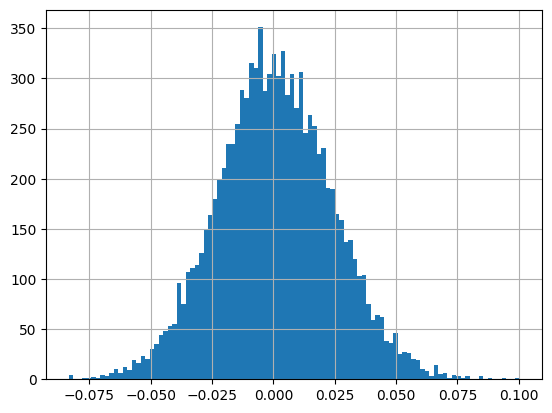

In [ ]:
fiteo_normal = norm(loc=strategy_lin.mean(), scale=strategy_lin.std())
pd.Series(fiteo_normal.rvs(10**4)).hist(bins=100)

In [ ]:
jsu_params = johnsonsu.fit(strategy_lin.dropna())
var_mod_jsu = johnsonsu.ppf(0.05, jsu_params[0], jsu_params[1], jsu_params[2], jsu_params[3])

In [ ]:
print(f"Empirico: {var_emp:.2%}\nModelado Normal: {var_mod_normal:.2%} \nModelado JohnsonSU: {var_mod_jsu:.2%}")

Empirico: -3.01%
Modelado Normal: -3.74% 
Modelado JohnsonSU: -3.31%


In [ ]:
def vaR(serie, v=0.95):
    var_emp = serie.quantile(1-v)
    var_mod_normal = norm.ppf(1-v, loc=serie.mean(), scale=serie.std())
    jsu_params = johnsonsu.fit(serie.dropna())
    var_mod_jsu = johnsonsu.ppf(1-v, jsu_params[0], jsu_params[1], jsu_params[2], jsu_params[3])
    print(f"Empirico: {var_emp:.2%}\nModelado Normal: {var_mod_normal:.2%} \nModelado JohnsonSU: {var_mod_jsu:.2%}")

In [ ]:
vaR(strategy_lin)

Empirico: -3.01%
Modelado Normal: -3.74% 
Modelado JohnsonSU: -3.31%


In [ ]:
vaR(benchmark_lin)

Empirico: -5.47%
Modelado Normal: -8.00% 
Modelado JohnsonSU: -5.59%


## cVaR (valor en riesgo condicional)  - Expected Shortfall

### Modelado con normal

$$  {\large \operatorname {ES} _{\alpha }(L)=\mu +\sigma {\frac {\varphi (\Phi ^{-1}(\alpha ))}{\alpha }}} $$

In [ ]:
mu = strategy_lin.mean()
sigma = strategy_lin.std()

In [ ]:
cVar_mod_norm = -mu + sigma * norm.pdf(norm.cdf(-0.01)**-1)/(-0.01)
print(f"cVaR Modelado Normal: {cVar_mod_norm:.2%}")

cVaR Modelado Normal: -12.25%


Mas distr: https://en.wikipedia.org/wiki/Expected_shortfall#Johnson's_SU-distribution

### Empirico

In [ ]:
tail = strategy_lin.loc[strategy_lin < -var_emp].tolist()

c = 0
for i in range(len(tail)):
    c += tail[i] * norm.pdf(x=tail[i], loc=mu, scale=sigma)

cVar_emp = c / len(tail)

print(f"cVaR Empirico: {cVar_emp:.2%}")

cVaR Empirico: -0.48%


## PayOff Ratio

- Asimetría dias/trades Ganadores/Perdedores
- No tiene en cuenta cantidad de cada uno, solo ratio en las medias de los ganadores/perdedores

In [ ]:
perdedores_st = strategy_log[strategy_log < 0]
ganadores_st = strategy_log[strategy_log > 0]

perdedores_bench = benchmark_log[benchmark_log < 0]
ganadores_bench = benchmark_log[benchmark_log > 0]

payoff_ratio_st = -ganadores_st.mean() / perdedores_st.mean()
payoff_ratio_bench = -ganadores_bench.mean() / perdedores_bench.mean()

payoff_ratio_st, payoff_ratio_bench

(0.6808656341872821, 0.9958552437025471)

## Profit Factor

- Ganancias TOTALES sobre perdidas totales

In [ ]:
perdedores_st = strategy_log[strategy_log < 0]
ganadores_st = strategy_log[strategy_log > 0]

perdedores_bench = benchmark_log[benchmark_log < 0]
ganadores_bench = benchmark_log[benchmark_log > 0]

profit_factor_st = -ganadores_st.sum() / perdedores_st.sum()
profit_factor_bench = -ganadores_bench.sum() / perdedores_bench.sum()

profit_factor_st, profit_factor_bench

(1.0975668187807095, 1.0027658535017978)

## Rachev ratio (Tails ratios)

### Solo las puntas (modelo mas chouzeano)

In [ ]:
cola_sup_st = strategy_lin.quantile(.95)
cola_inf_st = abs(strategy_lin.quantile(.05))

cola_sup_bench = benchmark_lin.quantile(.95)
cola_inf_bench = abs(benchmark_lin.quantile(.05))

rachev_st = cola_sup_st / cola_inf_st
rachev_bench = cola_sup_bench / cola_inf_bench

rachev_st, rachev_bench

(1.1377207283690596, 1.0792565152308646)

### Las medias

In [ ]:
q_inf_st = strategy_lin.quantile(0.05)
q_sup_st = strategy_lin.quantile(0.95)
q_inf_bench = benchmark_lin.quantile(0.05)
q_sup_bench = benchmark_lin.quantile(0.95)


cola_inf_st = strategy_lin[strategy_lin < q_inf_st].mean()
cola_sup_st = strategy_lin[strategy_lin > q_sup_st].mean()
cola_inf_bench = benchmark_lin[benchmark_lin < q_inf_bench].mean()
cola_sup_bench = benchmark_lin[benchmark_lin > q_sup_bench].mean()


rachev2_st = cola_sup_st / abs(cola_inf_st)
rachev2_bench = cola_sup_bench / abs(cola_inf_bench)

rachev2_st, rachev2_bench

(1.1804411437865543, 1.153995139497962)

### Forma mas realista, con las áreas

In [ ]:
from scipy.stats import norm

dist_st = strategy_log
q_inf_st, q_sup_st = dist_st.quantile(0.05), dist_st.quantile(0.95)
inf_st = [abs(x) for x in dist_st if x < q_inf_st]
sup_st = [x for x in dist_st if x > q_sup_st]

dist_bench = benchmark_log
q_inf_bench, q_sup_bench = dist_bench.quantile(0.05), dist_bench.quantile(0.95)
inf_bench = [abs(x) for x in dist_bench if x < q_inf_bench]
sup_bench = [x for x in dist_bench if x > q_sup_bench]


rachev3_st = (norm.pdf(sup_st) * sup_st).sum() / (norm.pdf(inf_st) * inf_st).sum()
rachev3_bench = (norm.pdf(sup_bench) * sup_bench).sum() / (norm.pdf(inf_bench) * inf_bench).sum()

rachev3_st, rachev3_bench

(1.0959490112842953, 0.9789700155014628)

### Representación Gráfica

In [ ]:
from scipy.stats import norm

norm(0,1).rvs(10)

array([-0.93695058, -0.08722173,  0.82888302,  0.63498955,  0.76724645,
        0.10405037, -1.40620876,  0.28037074,  0.31671821, -1.22020815])

<Axes: >

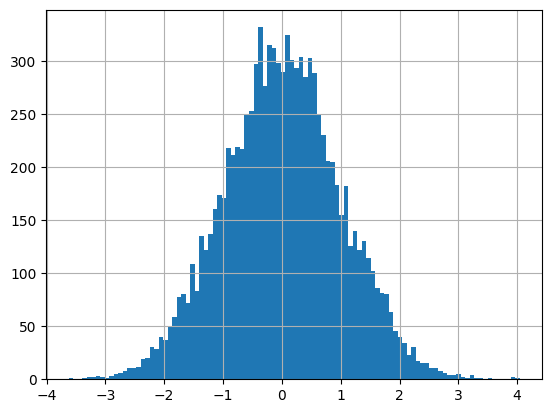

In [ ]:
pd.Series(norm(0,1).rvs(10**4)).hist(bins=100)

Text(0.5, 1.0, 'Tail Ratio')

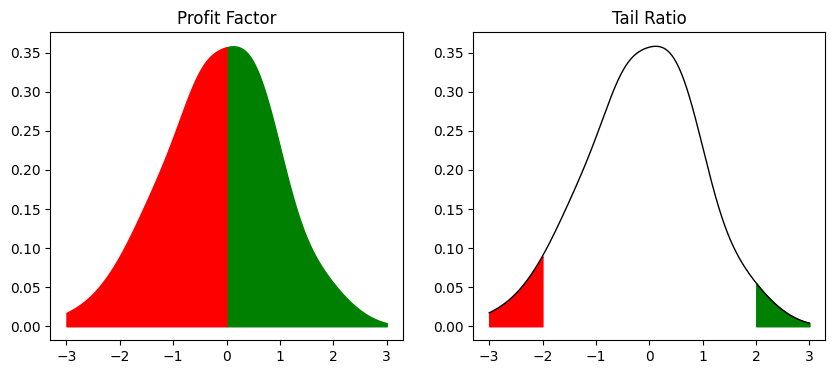

In [ ]:
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,4), ncols=2)

# Armo distribucion aleatoria
dist = pd.Series(norm(0,1).rvs(10**2))

# Genero un kernel de funcion de densidad
kde = gaussian_kde(dist)

# Genero puntos del eje x equidistantes
x = np.linspace(-3, 3, 1000)

ax[0].fill_between(x, kde(x), where=x>0, color='g')
ax[0].fill_between(x, kde(x), where=x<0, color='r')
ax[0].set_title('Profit Factor')

ax[1].plot(x, kde(x), '-k', lw=1)
ax[1].fill_between(x, kde(x), where=x>2, color='g')
ax[1].fill_between(x, kde(x), where=x<-2, color='r')
ax[1].set_title('Tail Ratio')


## Common sense ratio

In [ ]:
csr_st = rachev3_st * profit_factor_st
csr_bench = rachev3_bench * profit_factor_bench

csr_st, csr_bench

(1.2028772698611678, 0.9816777031469925)

## Outlier win/loss ratio

* que tan fuertes son las voladuras respecto a una suba media
* que tan fuertes son los derrapes contra una bajada media

In [ ]:
outliers_w = strategy_lin.quantile(.99)
outliers_l = strategy_lin.quantile(.01)
w = strategy_lin[strategy_lin >= 0]
l = strategy_lin[strategy_lin < 0]

owr = outliers_w.mean() / w.mean()
owr

6.437668943805321

In [ ]:
olr = outliers_l.mean() / l.mean()
olr

3.550224895405468

## Valores maximos y minimos por timeframe

### Diario

In [ ]:
strategy_lin.idxmax(), strategy_lin.max()

(Timestamp('2002-08-28 00:00:00'), 0.5654195545983902)

In [ ]:
strategy_lin.idxmin(), strategy_lin.min()

(Timestamp('2019-08-12 00:00:00'), -0.42086781657600314)

### Semanal

In [ ]:
semanal = strategy.resample('W').last().pct_change()
semanal.idxmax(), semanal.max()

(Timestamp('2002-10-06 00:00:00', freq='W-SUN'), 0.3004710788410321)

In [ ]:
semanal.idxmin(), semanal.min()

(Timestamp('2019-08-18 00:00:00', freq='W-SUN'), -0.40713161813671483)

### Mensual

In [ ]:
mensual = strategy.resample('M').last().pct_change()

mensual.idxmax(), mensual.max()

(Timestamp('2002-10-31 00:00:00', freq='M'), 0.5831265749252474)

In [ ]:
mensual.idxmin(), mensual.min()

(Timestamp('2019-08-31 00:00:00', freq='M'), -0.5163778743614453)

### Trimestral

In [ ]:
trimestral = strategy.resample('3M').last().pct_change()

trimestral.idxmax(), mensual.max()

(Timestamp('2002-12-31 00:00:00', freq='3M'), 0.5831265749252474)

In [ ]:
trimestral.idxmin(), mensual.min()

(Timestamp('2019-09-30 00:00:00', freq='3M'), -0.5163778743614453)

### Anual

In [ ]:
anual = strategy.resample('Y').last().pct_change()

anual.idxmax().year, anual.max()

(2003, 1.77690703166434)

In [ ]:
anual.idxmin().year, anual.min()

(2020, -0.4039607679222622)

### Anual grafico comparativo

<Axes: xlabel='Date'>

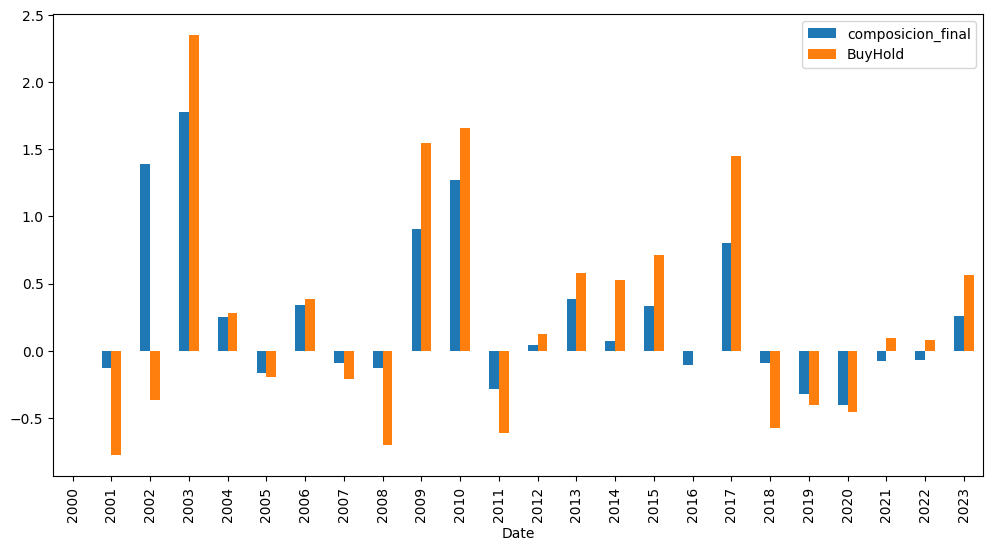

In [ ]:
anual_st = strategy.resample('Y').last().pct_change()
anual_bench = benchmark.resample('Y').last().pct_change()

df = pd.concat([anual_st, anual_bench], axis=1)
df.index = df.index.year
df.plot(kind='bar', figsize=(12,6))

y ahora, la magia... ojo igual ehhh

# Backtest Dashboard

In [ ]:
!pip install QuantStats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.3 MB/s eta 0:00:00


[Performance Metrics]

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-12-13  2000-12-13
End Period                 2023-06-12  2023-06-12
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      98.0%

Cumulative Return          2,572.58%   24.21%
CAGR﹪                     15.72%      0.97%

Sharpe                     0.58        0.36
Prob. Sharpe Ratio         99.73%      96.93%
Smart Sharpe               0.54        0.33
Sortino                    0.89        0.62
Smart Sortino              0.82        0.57
Sortino/√2                 0.63        0.43
Smart Sortino/√2           0.58        0.4
Omega                      1.15        1.15

Max Drawdown               -77.02%     -98.98%
Longest DD Days            1587        5143
Volatility (ann.)          36.94%      78.22%
R^2                        0.54        0.54
Information Ratio          -0.01       -0.01
Calmar          

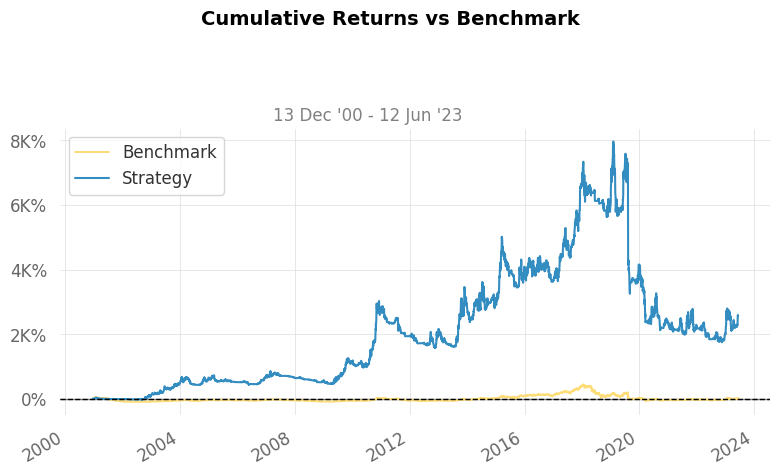

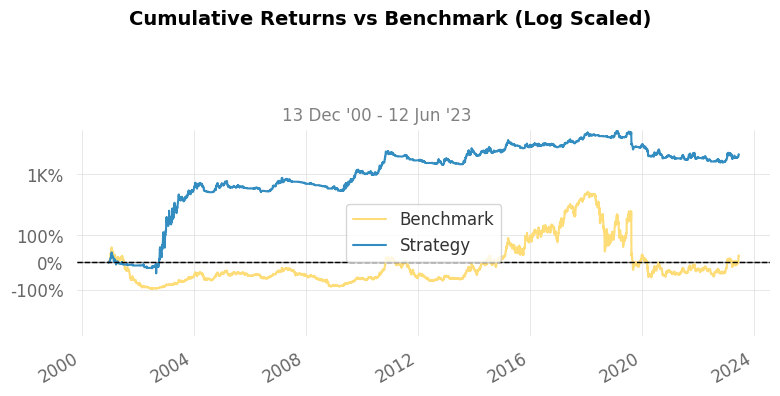

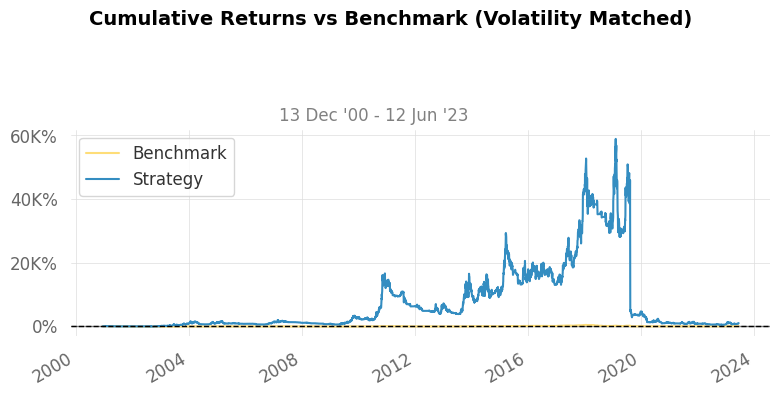

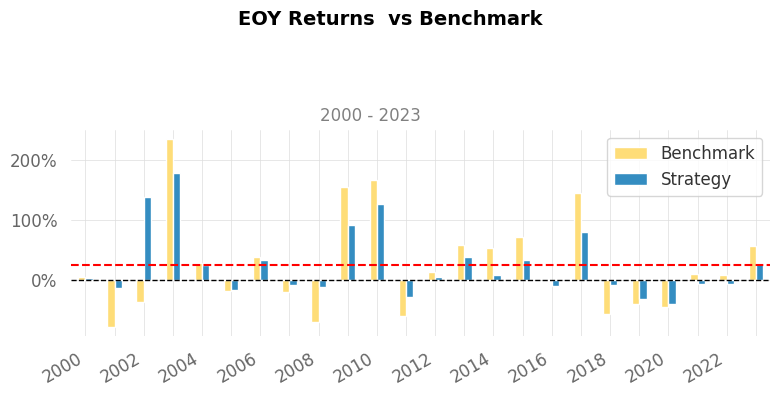

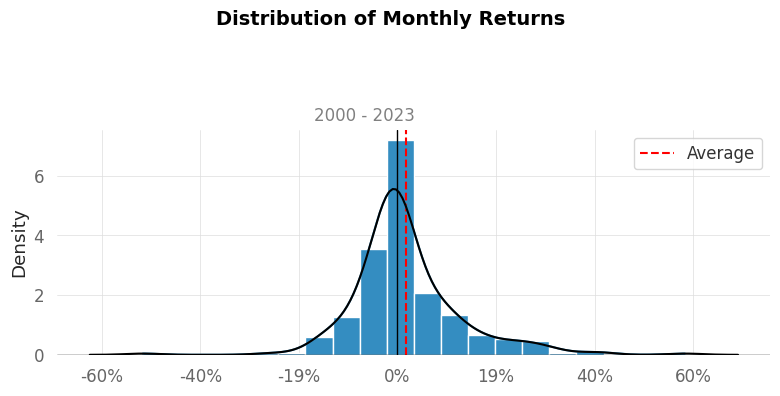

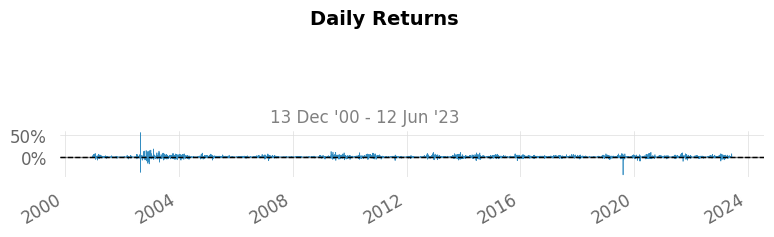

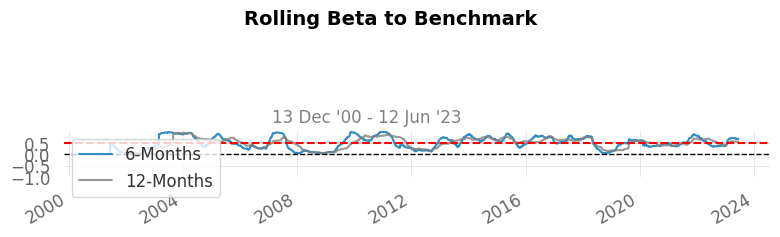

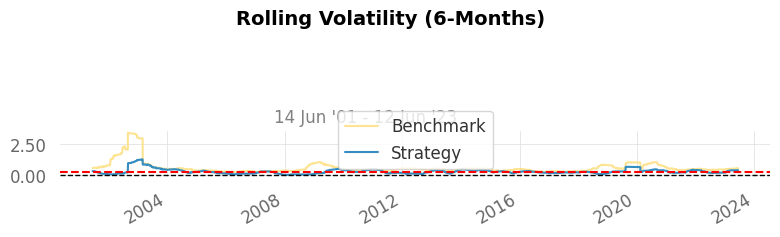

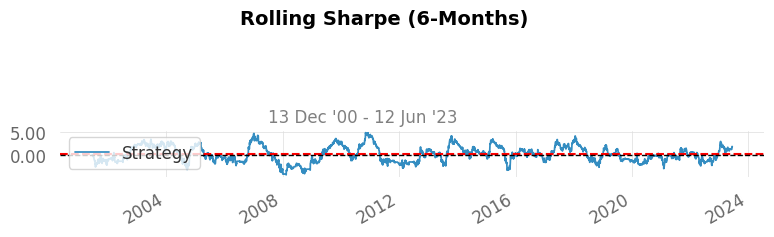

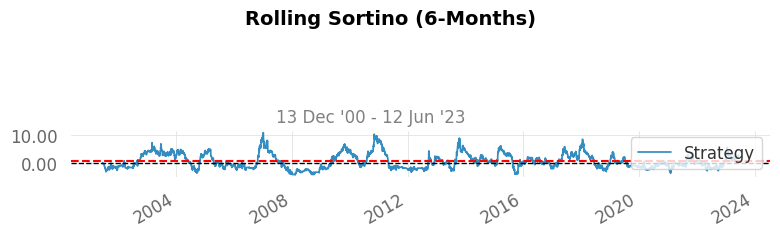

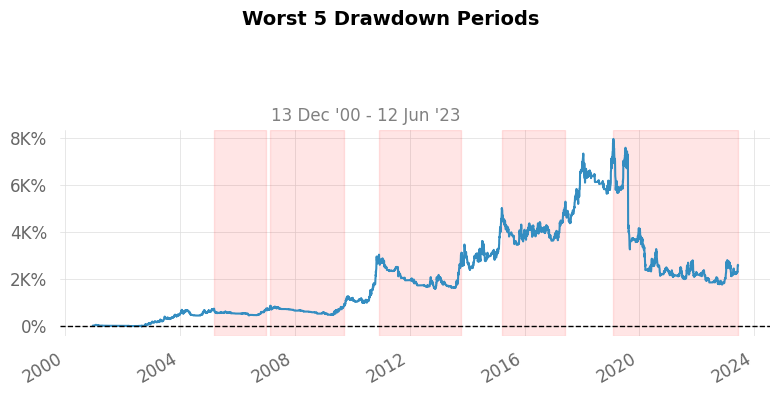

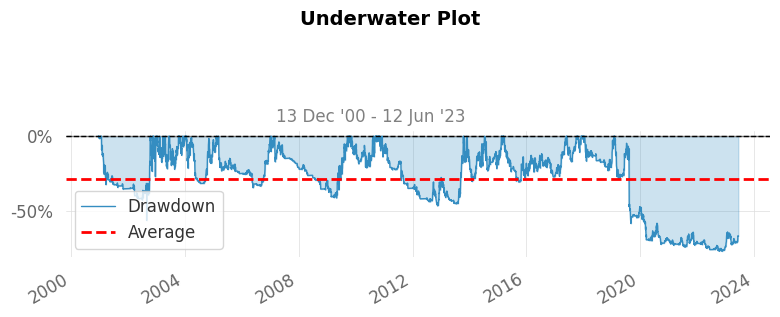

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


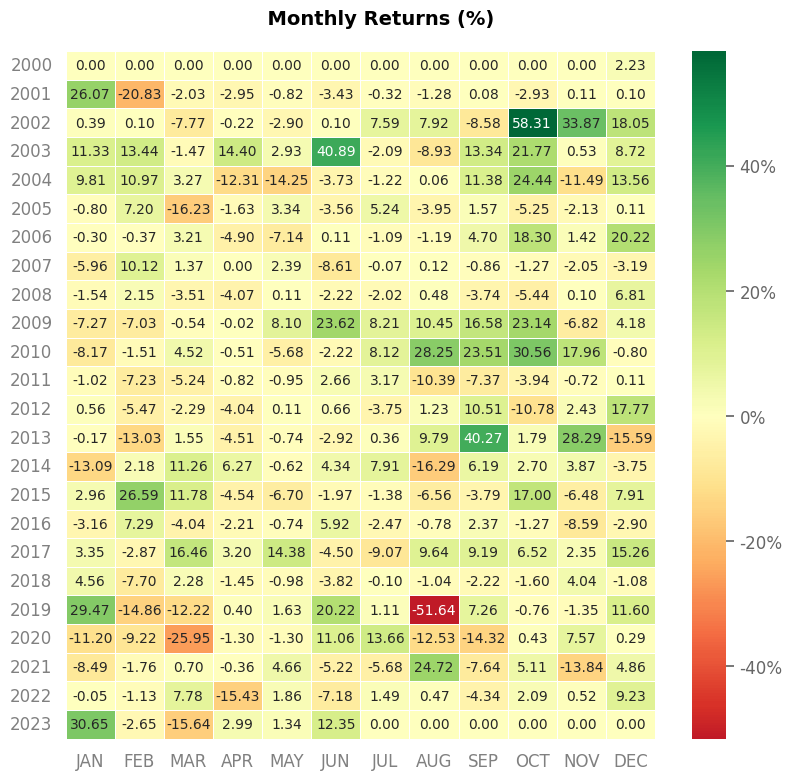

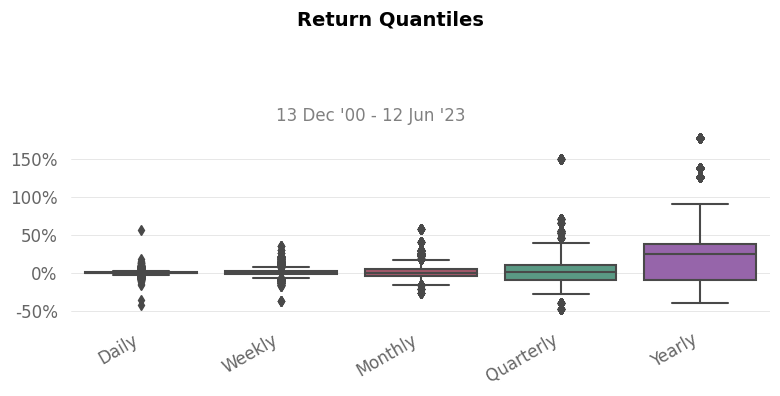

In [ ]:
# !pip install QuantStats
import quantstats as qs
#qs.extend_pandas()

qs.reports.full(strategy_lin, benchmark_lin)